# 0. Setup

In [1]:
%%capture
!pip install eikon
!pip install more_itertools

In [72]:
import eikon as ek
from datetime import datetime
from datetime import timedelta
from eikon_wrapper import get_data
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Set the app key created at "api_key_lk" in Eikon (see readme for details)
ek.set_app_key("716a396b553b441680427f612d2f89735c88bf9e")

# 1. Interesting Eikon Data Items

The below is a collection of some Data Items from the Eikon platform we've found useful. Also refer to Fosse (2022) for more items regarding bonds.

In [4]:
#Market capitalization fields 
fields = ['TR.CompanyMarketCap.Date','TR.CompanyMarketCap', 'TR.PriceClose', 'TR.CompanyMarketCap.Currency'] 

#Fundamental stock data fields
profits = ['TR.TotalRevenue', 'TR.GrossProfit','TR.EBITDA','TR.EBIT', 'TR.F.NetIncAfterTax']#, 'TR.EV','MKT_CAP']
balance = ['TR.F.TotAssets','TR.F.TotCurrAssets','TR.F.TotLiab','TR.F.TotCurrLiab', 'TR.F.LTDebtPctofTotAssets','TR.F.STDebtPctofTotAssets',"TR.InvtrPriceToBook"]#TR.F.TotLiab(Period=FY0)
cash_flow = ['TR.F.LeveredFOCF']

fundamental_data = profits + balance + cash_flow 
reported_dates = ['TR.TotalRevenue.periodenddate']

#Company meta data fields
geography = ['TR.ExchangeMarketIdCode', 'TR.HeadquartersRegionAlt', 'TR.HeadquartersCountry', 'TR.HQStateProvince']
sectors = ['TR.TRBCEconomicSector', 'TR.TRBCBusinessSector', 'TR.TRBCIndustryGroup', 'TR.TRBCIndustry', 'TR.TRBCActivity']
founded = ['TR.OrgFoundedYear']

meta_data = geography + founded + sectors

#Broker estimates
#params_new["Period"] = "FY1"    

fields = ["TR.EPSMean","TR.EPSMean.periodenddate","TR.EBITMean",'TR.RevenueMean',
              "TR.ROAMean","TR.ROEMean","TR.FCFMean","TR.TotalAssets","TR.MeanPctChg(Period=FY1,WP=60d)"]

# 2. Examples

## Example 0) Screen companies

Below, we've created a couple of simple screens we used outselves in our Master's thesis. The first one gets all Norwegian oil-related companies, the second gets all global oil-related companies, and the last gets all global financial companies (all with some extra criterias).

In [5]:
# For all these screens, we're only interested in the names of the companies
# (to inspect what companies come out)
company_names = ["TR.CommonName"]

In [9]:
# Norwegian oil companies
# First create the screening string (see the readme for more on this)
oil_osebx_screen = 'SCREEN(U(IN(Equity(active,public,primary))),' \
    'TR.CompanyMarketCap>=500000, IN(TR.ExchangeMarketIdCode,"XOSL"),'\
    'IN(TR.TRBCBusinessSectorCode,"5010","5020","5030"), CURN=USD)'

# Get companies in screen and show the first 5
osbx_companies, e = get_data(oil_osebx_screen, company_names, {})
osbx_companies = osbx_companies.set_index("Instrument"); print(f"Number of companies: {osbx_companies.shape[0]}")
osbx_companies.head(5)

Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

Number of companies: 46


,Company Common Name
Instrument,
BONHR.OL,Bonheur ASA
DNO.OL,Dno ASA
ODF.OL,Odfjell SE
EQNR.OL,Equinor ASA
FRO.OL,Frontline Ltd


In [241]:
# Global oil companies
oil_global_screen = 'SCREEN(U(IN(Equity(active,public,primary))),'\
    'TR.CompanyMarketCap>=500000, IN(TR.TRBCBusinessSectorCode,"5010","5020","5030"), CURN=USD)'


# Get and show data
global_oil, e = get_data(oil_global_screen, company_names, {})
global_oil = global_oil.set_index("Instrument"); print(f"Number of companies: {global_oil.shape[0]}")
global_oil.head(5)

Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

2022-08-22 12:11:48,792 P[18908] [MainThread 13432] Failed to decode response to json: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd"><html><head><title>Sign In</title><meta http-equiv="X-UA-Compatible" content="IE=EmulateIE7"/><meta http-equiv="content-type" content="text/html; charset=utf-8"/><META page=login><link rel="icon" type="image/vnd.microsoft.icon" href="/auth/images/favicon.png"/><link rel="shortcut icon" href="/auth/images/favicon.png"/><link rel="stylesheet" type="text/css" href="/auth/css/charcoal_commonstyles_spr.css?v=_3.44.160.01"/><link rel="stylesheet" type="text/css" href="/auth/css/refinitiv_charcoal_loginstyles_spr.css?v=_3.44.160.01"/><script type="text/javascript" src="/auth/js/signin_spr.js?v=_3.44.160.01"></script><script type="text/javascript" src="/js/as.js?v=_3.44.160.01"></script><script src="/auth/js/jquery-1.10.1.min.js"></script><script src="/auth/js/jquery-as.js?v=_3.44.160.01"></script><script type='text/jav

AttributeError: 'NoneType' object has no attribute 'set_index'

In [182]:
# Global financial companies
financial_global_screen = 'SCREEN(U(IN(Equity(active,public,primary))),'\
    'TR.CompanyMarketCap>=500000, IN(TR.TRBCBusinessSectorCode,"5510"), CURN=USD)'

global_financial, e = ek.get_data(financial_global_screen, company_names, {})
global_financial = global_financial.set_index("Instrument"); print(f"Number of companies: {global_financial.shape[0]}")
global_financial.head(5)

Number of companies: 4602


,Company Common Name
Instrument,
KAER.VI,BKS Bank AG
TIRO.VI,Bank fuer Tirol und Vorarlberg AG
000416.SZ,Minsheng Holdings Co Ltd
NEDJ.J,Nedbank Group Ltd
SBKJ.J,Standard Bank Group Ltd


## Example 1) Stock and fundamental data retrival

### Founded year for oil companies

To get started, we'll start with a simple example where we get the years the global oil companies were founded. In short, we first create a list of tickers from the screens above. Then, we define what fields we're interested in, then we fetch the data.

Please note in the data frame result that `PUMA.LZ` do not have a year. Already, we see that Eikon suffers from faulty or missing data. Please use this example as a warning to always inspect the data you get from Eikon because there can always be faults with the data from Eikon's side.

In [183]:
# Tickers to get
lst_of_tickers = global_oil.index.to_list()

# Fields we want data for for the above tickers (see Data Item Browser or our/Fosse (2022)'s list of common fields)
fields = ['TR.OrgFoundedYear']

# Eikon parameters (none required as we're getting static data)
ek_params = {}

df, err = get_data(lst_of_tickers, fields, ek_params)
df

Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

,Instrument,Organization Founded Year
0,PNX.PS,2002
1,NEWH.PK,2006
2,OMVV.VI,1956
3,600403.SS,1998
4,GALP.LS,1999
...,...,...
2023,PUMA.LZ,0
2024,PGS.HN,2007
2025,PVG.HN,2007
2026,TPL.CN,2001


### Fundamental and stock price data

In this example, we are interested to find global publicly traded oil companies' fundamental data quarterly fundamental data, and their stock price, in daily format. 

To begin, we use a single ticker in the oil space, AKRBP.OL (which really did a "kule" during the spring of 2022). We chose this ticker at random from the above screening result (`global_oil`). We are interested in its stock price possibly from 2020 and will just use `get_data` and hope that it hands us some interesting data without asking for specific fields. Surely, if asking for a stock, with no more information, `get_data` would understand that we are interested in stock price data. 

In [184]:
ticker = "AKRBP.OL"
start_date = "2020-01-01"
end_date = "2022-05-06" # A very nice man's birthday (according to some)
fields = None

params = {"SDate": start_date, "EDate": end_date}

df, err = get_data(ticker, fields, params)
df

[INFO] Number of dates: 591
[INFO] Number of tickers at once: 1
[INFO] Max time window length: 357


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

AKRBP.OL,HIGH,CLOSE,LOW,OPEN,VOLUME,ticker
Date,,,,,,
2020-01-02,293.3,289.0,287.6,288.1,580227,AKRBP.OL
2020-01-03,295.8,292.9,291.4,293.6,553248,AKRBP.OL
2020-01-06,297.7,296.3,292.6,297.7,513372,AKRBP.OL
2020-01-07,297.1,295.7,293.0,294.9,618715,AKRBP.OL
2020-01-08,297.9,295.3,294.4,297.5,672176,AKRBP.OL
...,...,...,...,...,...,...
2022-05-02,339.7,332.2,323.4,339.7,808277,AKRBP.OL
2022-05-03,343.2,343.2,323.5,331.0,771037,AKRBP.OL
2022-05-04,352.1,351.0,340.9,345.0,699762,AKRBP.OL


Wouldn't you know it. The `get_data` function gives us the daily stock data also with intraday Volume. 

Now, we are interested in how the financials of AKER.BP has been during the same time window. IMPORTANT NOTE ABOUT FREQUENCY:

> Note that we below use frequency AND period, then iterate through time one fical quarter (`FQ`) at a time, and returning the quarterly data at that time point (`FQ0`). If we do not specify period, `get_data` will return 4 copies of the yearly financial, one for each quarter. NOTE THIS.

We use the above cell with interesting fields for inspiration for what data items we could use. We, of course, could also use the Eikon Data Item Browser.

And for good measure, let's turn the dial to 11 and get all of `AKER.BP`'s annual reports since the year 2000!

In [185]:
ticker = "AKRBP.OL"

start_date = '2000-01-01'
end_date = '2022-04-21'
frequency = "FQ"  # <-- We understand this intuitivly (refer to above note for more detail on this)
period = "FQ0"  # <-- However, this is very important to note, needed to overwrite Eikon's
                # standard of returning yearly data regardless of sampling frequency
curn = "USD"  # <-- What on earth could this possibly do?!?! ;)

date = ['TR.TotalRevenue.date']  # <-- Pro tip: use the date atrtibute of one of the fields included in the search
profit = ['TR.TotalRevenue', 'TR.GrossProfit','TR.EBITDA','TR.EBIT', 'TR.F.NetIncAfterTax']
balance = ['TR.F.TotAssets', 'TR.F.TotLiab']

fields = date + profit + balance
ek_params = {"SDate": start_date, "EDate": end_date, "Frq":frequency, "period":period, "curn":curn}
             
df, err = get_data(ticker, fields, ek_params)
df

[INFO] Number of dates: 63
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

,Instrument,Date,Total Revenue,Gross Profit,EBITDA,EBIT,Net Income after Tax,Total Assets,Total Liabilities
0,AKRBP.OL,2006-06-30T00:00:00Z,0,0,0.0,0.0,320.81118,<NA>,<NA>
1,AKRBP.OL,2006-09-30T00:00:00Z,0,-171542,-2199210.998,-2199210.998,-498265.76248,2841282.7061,3598550.30355
2,AKRBP.OL,2006-12-31T00:00:00Z,0,-798794,-3575630.826,-3575630.826,-776947.04614,233608811.44911,77295116.15967
3,AKRBP.OL,2007-03-31T00:00:00Z,0,-541811,-3304305.06,-3304305.06,-951208.40056,220798381.52571,61525708.0825
4,AKRBP.OL,2007-06-30T00:00:00Z,0,-952083,-36077349.578,-36205953.274,-5792294.15342,234434930.34319,75832144.07068
...,...,...,...,...,...,...,...,...,...
58,AKRBP.OL,2020-12-31T00:00:00Z,833508000,691440000,622691000.0,333283000.0,129467000.0,12420091000.0,10432810000.0
59,AKRBP.OL,2021-03-31T00:00:00Z,1133238000,957332000,878190000.0,620636000.0,127030000.0,12241198000.0,10252205000.0
60,AKRBP.OL,2021-06-30T00:00:00Z,1123754000,965519000,854535000.0,614162000.0,153811000.0,13075850000.0,11045546000.0
61,AKRBP.OL,2021-09-30T00:00:00Z,1562675000,1353877000,1249866000.0,1003019000.0,205834000.0,13582017000.0,11454157000.0


This is pretty fantastic! Just contemplate what you just did. That's 63 quarterly reports in one easy swoooosh. And with this our first example is complete. Again, please note that, e.g., `Total Revenue` is 0 for several entries here, again because Eikon is flawed. Another thing, Aker BP is the result of several mergers throughout its history (most notably the merger with BP Norway in 2016), so the financial data might behave strangely at times, so use your judgement. Always check your data!

### The grand finale

Finally, let's pump this up to get this data for all oil companies in the world. See how we just change the list of tickers we're interested in and keep all other parameters constant (that's orthogonal programming for you, dear sir).

In [186]:
df, err = get_data(global_oil.index.to_list(), fields, ek_params)
df

[INFO] Number of dates: 62
[INFO] Number of tickers at once: 48


Ticker:   0%|          | 0/43 [00:00<?, ?it/s]

KeyboardInterrupt: 

Unbelievable. 87 500 quartely reports, sheeesh. And it only took 5-6 minutes on our super-slow internet connnection here we sit in Zambia making this tool for you, dear student at NTNU.

## Example 2) Bond data

In this example, we want to collect data for a series of bonds. We want to see what they are trading at, and find other interesting information like their maturity, and principal. We'll start with getting the historical prices for a specific bond we're interested in. This will, of course, scale to more by just looping over all the bond `RIC`s you're interested in. I'd like to see you `for` loop in Excel.

### The bond ticker set

The tickers we'll work with we've collected from the _"Advanced Search - Government and Corporate Bonds"_ function in Eikon. Writing _"GOVSRCH"_ into the search bar and hitting Enter takes you directly there. Please see Fosse (2021) for more on how this tool works. In short, we've put on some simple filters and exported a list of bond _RICs_ into an Excel file. We load in the RICs with `pandas`.

In [159]:
# The RIC column hides under the name 'Preferred RIC', don't know why..
bond_rics = pd.read_excel("data/bond_rics.xlsx")["Preferred RIC"].to_list()
print(len(bond_rics), "bond rics")
bond_rics[:5]

1000 bond rics


['NO0012555558=OL',
 'GB248686359=',
 'XS1639098398=TE',
 'GB165801202=',
 'NO1080260=']

### 2.1 Historical bond price data

For the first example, we want to show how one can collect bond price data over time for several bonds at a time. Below, we request the bond price in dollar from January 1st until today's date for the 100 first RICs in the list (there's 1 000 in total, but for sake of example we only load a subset to save time, but feel free to go crazy here!).

In [161]:
curn = "USD"

start_date = '2010-01-01'
end_date = datetime.now().strftime("%Y-%m-%d")

fields = []  # <-- We just want the price data so no need to specify fields

ek_params = {"SDate": start_date, "EDate": end_date, "curn": curn}

# Call Eikon server and show result
df, err = get_data(bond_rics[:100], fields, ek_params)
df

2022-08-08 17:04:06,674 P[18908] [MainThread 13432] Error with NO0012555558=OL: No data available for the requested date range
2022-08-08 17:04:06,676 P[18908] [MainThread 13432] NO0012555558=OL: No data available for the requested date range | 


[INFO] Number of dates: 38
[INFO] Number of tickers at once: 9


Ticker:   0%|          | 0/100 [00:00<?, ?it/s]

2022-08-08 17:04:08,099 P[18908] [MainThread 13432] Error with NO0012555558=OL: No data available for the requested date range
2022-08-08 17:04:08,099 P[18908] [MainThread 13432] NO0012555558=OL: No data available for the requested date range | 
2022-08-08 17:04:10,324 P[18908] [MainThread 13432] Error with XS1639098398=TE: No data available for the requested date range
2022-08-08 17:04:10,332 P[18908] [MainThread 13432] XS1639098398=TE: No data available for the requested date range | 
2022-08-08 17:04:50,426 P[18908] [MainThread 13432] Error with CH182300055=: No data available for the requested date range
2022-08-08 17:04:50,426 P[18908] [MainThread 13432] CH182300055=: No data available for the requested date range | 
2022-08-08 17:04:53,372 P[18908] [MainThread 13432] Error with XS1865149550=TE: No data available for the requested date range
2022-08-08 17:04:53,372 P[18908] [MainThread 13432] XS1865149550=TE: No data available for the requested date range | 
2022-08-08 17:05:09,34

,HIGH,CLOSE,LOW,OPEN,COUNT,ticker
Date,,,,,,
2022-06-09,8.301,8.301,8.301,8.301,-1,GB248686359=
2022-06-10,8.608,8.301,8.301,8.301,-1,GB248686359=
2022-06-13,8.735,8.735,8.672,8.672,-1,GB248686359=
2022-06-21,9.493,9.361,8.984,9.062,-1,GB248686359=
2022-06-22,9.351,9.177,9.021,9.269,-1,GB248686359=
...,...,...,...,...,...,...
2022-08-02,7.955,7.955,7.955,7.955,-1,05946KAG6=
2022-08-03,8.178,8.012,7.737,7.957,-1,05946KAG6=
2022-08-04,8.178,8.016,7.737,7.957,-1,05946KAG6=


In [162]:
err

,error
NO0012555558=OL,Error code -1 | NO0012555558=OL: No data avail...
XS1639098398=TE,Error code -1 | XS1639098398=TE: No data avail...
CH182300055=,Error code -1 | CH182300055=: No data availabl...
XS1865149550=TE,Error code -1 | XS1865149550=TE: No data avail...
NO0010835143=TE,Error code -1 | NO0010835143=TE: No data avail...
NO0010835150=TE,Error code -1 | NO0010835150=TE: No data avail...
NO0010835176=TE,Error code -1 | NO0010835176=TE: No data avail...
CH200717422=,Error code -1 | CH200717422=: No data availabl...
XS2008159803=TE,Error code -1 | XS2008159803=TE: No data avail...


There we go, in around one and a half minute, we have 10 years of daily price data for 100 different corporate bonds on our hands (except for the ones where there just isn't any price data). The ones that didn't have data in the Eikon database are in the `err` dataframe above.

Now, let's proceed to get some cross-sectional data on these bonds.

### 2.2 Mass download of bond data

Here we'll try to get a lot of data about a large number of bonds. The list of bonds we're using is the same as in the above example. Here it is nice to mention that for this kind of data, it can be just as efficient to just export all the columns you're interested in directly from Eikon into an Excel file. As opposed to for the time-series case above, this is a simple rectangular dataframe where each row contains all requested info for that unique bond.

In [177]:
fields = [
    "TR.IssuerTickerCode",
    "TR.TRBCIndustry",
    "TR.FiMaturityStandardYield",
    "TR.IssuerRating",
    "TR.IR.RatingDate",
    "TR.CouponRate",
    "TR.CA.AmtOutstanding",
    "TR.TRESGScore",
]

ek_params = {"curn": curn}

# Call Eikon server and show result (we're not using date parameters as this data is static)
df, err = get_data(bond_rics, fields, ek_params)
df

Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

,Instrument,Issuer Ticker,TRBC Industry Name,Yield To Maturity,Issuer Rating,Date,Coupon Rate,Amount Outstanding,ESG Score
0,NO0012555558=OL,SOONS,Banks,<NA>,A2,2018-09-04T00:00:00Z,5.19,100000000.0,<NA>
1,GB248686359=,VMUK,Banks,8.445054,Baa2,2022-06-27T00:00:00Z,8.25,350000000.0,52.883237
2,XS1639098398=TE,ISP,Banks,<NA>,A1,2022-04-27T00:00:00Z,5.879,200000000.0,90.950224
3,GB165801202=,BARC,Banks,7.436301,BBB,2022-07-19T00:00:00Z,5.875,1250000000.0,84.721496
4,NO1080260=,SOONS,Banks,5.453719,A2,2018-09-04T00:00:00Z,4.52,66000000.0,<NA>
...,...,...,...,...,...,...,...,...,...
995,XS1649337174=LU,CBKG,Banks,<NA>,A2,2022-06-30T00:00:00Z,10.8,9000000.0,76.472103
996,AT0000A1X3G7=TEMK,VORARH,Banks,<NA>,P-1,2018-06-08T00:00:00Z,3.75,3450000.0,<NA>
997,CA064151XP3=,BNS,Banks,<NA>,WR,2021-09-03T00:00:00Z,0.0,<NA>,79.825106
998,XS1627839472=GSIL,GSILT,Investment Banking & Brokerage Services,<NA>,A1,2020-10-29T00:00:00Z,5.0,100000000.0,<NA>


Honky-doodle-doo, isn't that jolly-golly? Such data, much wow. Okay, bonds are not our wheel house (perma-bull, risk-seeking, retail investors as we are), so we'll round out this notebook in the final example on macro and commoditity time-series below.

## Example 3) Macro data

In this last example, we want to collect data on some interesting macro economic varibales. We want the oil price, which could feed into example 1) and we want the interest rate in the US, which is intersting given example 2) 

This time, we start by using the eikon refinitiv desktop search tool to look up the tickers for BRT- and the US 10y rate. Again, we use the get_data function, which will under the hood use the right functionality (ek.get_timeseries) but we do not have to think about that!

In [192]:
start_date = '2012-01-01'
end_date = '2022-04-21'
macro_params = {"SDate": start_date, "EDate": end_date}
tickers = ["US10YT=RR", "BRT-", "CLc1", "CLc12", "CLc60", ".VIX", "EUR=", "GBP=", "CNY="]


df, err = get_data(tickers, None, macro_params)
df

[INFO] Number of dates: 2578
[INFO] Number of tickers at once: 1
[INFO] Max time window length: 416


Ticker:   0%|          | 0/54 [00:00<?, ?it/s]

,HIGH,CLOSE,LOW,OPEN,ticker,VALUE,VOLUME,COUNT
Date,,,,,,,,
2012-01-03,1.965,1.956,1.876,1.876,US10YT=RR,<NA>,<NA>,<NA>
2012-01-04,2.012,1.984,1.934,1.96,US10YT=RR,<NA>,<NA>,<NA>
2012-01-05,2.021,1.996,1.944,1.981,US10YT=RR,<NA>,<NA>,<NA>
2012-01-06,2.046,1.958,1.946,1.995,US10YT=RR,<NA>,<NA>,<NA>
2012-01-09,1.986,1.956,1.919,1.958,US10YT=RR,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...
2022-04-15,6.3765,6.3705,6.3654,6.376,CNY=,<NA>,<NA>,4691
2022-04-18,6.3748,6.363,6.3604,6.3739,CNY=,<NA>,<NA>,4378
2022-04-19,6.3962,6.393,6.3675,6.3685,CNY=,<NA>,<NA>,5001


With the data in hand, let's put it to good use.

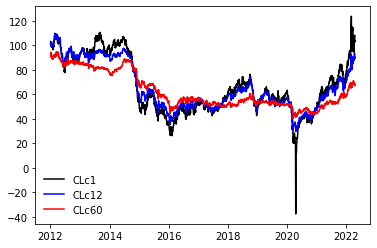

In [195]:
for c, color in zip(["CLc1", "CLc12", "CLc60"], ["black", "blue", "red"]):
    d = df[df.ticker == c]
    
    plt.plot(d.index, d.CLOSE, label=c, color=color)
    plt.legend(frameon=False)

Ah, that's the 1, 12, and 60 month forward prices for the NYMEX light sweet crude oil from 2012 until April 2022. Note, if we plotted $\texttt{CLc}_i \quad \forall i \in 1...60$, we would have the entire 5 year forward curve plotted for every single trading day during the last 10 years. \*sound of mic dropping\*.

NB: We didn't use the standard, built-in pyplot colors, as that reeks of n00b programming, and it makes it impossible to be taken seriously.

## Example 4) Green bonds

In this example, we will get a list of bond identifiers from an Excel sheet, and get daily price data for them. The identifiers are so called ISIN-values (International Securities Identification Number), an international standard for security id's. So, do you think this is what Eikon uses? Of course not. Therefore, we need to convert them into Eikon's own identifier, the RIC, before we can get the data.

In [12]:
# Start by reading in the tickers
bonds = pd.read_excel("data/Data_for_experiments_Bondliquidity.xlsx")
bonds

,ISIN,IssueDate,Type
0,US75884RAT05,2014-05-16,Green
1,US037833BU32,2016-02-23,Green
2,US373334KE00,2016-03-08,Green
3,FR0013170834,2016-05-20,Green
4,JP376280AG96,2016-09-16,Green
...,...,...,...
195,US192714AD56,2020-03-06,Vanilla
196,USP2867KAK27,2020-03-06,Vanilla
197,JP385020BM51,2021-05-20,Vanilla
198,JP344360AL66,2020-06-16,Vanilla


Now that we have the list of tickers and dates, we'll convert them to RICs below. Also, since some of the ISINs don't have RICs, we remove them as well.

In [81]:
# Convert ISIN to RIC
ric_list = ek.get_symbology(
    bonds.ISIN.to_list(),
    from_symbol_type="ISIN",
    to_symbol_type="RIC",
    best_match=False,
).dropna(subset=["RICs"])

In [82]:
# Update the bond list with only the bonds for which we have a RIC
bonds = bonds[bonds.ISIN.isin(ric_list.index)]
bonds.head()

,ISIN,IssueDate,Type,RIC
0,US75884RAT05,2014-05-16,Green,75884RAT0=
1,US037833BU32,2016-02-23,Green,037833BU3=
2,US373334KE00,2016-03-08,Green,373334KE0=
3,FR0013170834,2016-05-20,Green,FR0013170834=
4,JP376280AG96,2016-09-16,Green,JP00034307=


In [83]:
# Add a column with the RIC to the original dataframe of bonds and dates
bonds.loc[:, "RIC"] = list(map(lambda x: x[0], ric_list.RICs.to_list()))
bonds.head()

,ISIN,IssueDate,Type,RIC
0,US75884RAT05,2014-05-16,Green,75884RAT0=
1,US037833BU32,2016-02-23,Green,037833BU3=
2,US373334KE00,2016-03-08,Green,373334KE0=
3,FR0013170834,2016-05-20,Green,FR0013170834=
4,JP376280AG96,2016-09-16,Green,JP00034307=


Ok, now we're ready to get the data. We'll get it in a slightly different fashion than before. This is since we're now getting data for different time periods for all the different bonds. It's impractical to get the data all at once. Therefore, we'll iterate over each bond RIC and get the data for the day after the issue date and the next 60 days (2 months)

In [85]:
# In the example, we'll just get the first 10 bonds, but just remove the line to get all
bonds = bonds.iloc[:10, :]

curn = "USD"
dfs = []

for i, (date, ric) in enumerate(zip(bonds.IssueDate, bonds.RIC)):
    if i % 10 == 0: print(f"Getting bond {i + 1} of {bonds.shape[0]}")
        
    start_date = (date + timedelta(days=1)).strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=61)).strftime("%Y-%m-%d")

    fields = ["TR.BidPrice.Date", "TR.BidPrice", "TR.AskPrice"]  # <-- We just want the price data so no need to specify fields
    #fields = []
    
    ek_params = {"SDate": start_date, "EDate": end_date, "curn": curn}

    # Call Eikon server and show result
    df, err = get_data(ric, fields, ek_params)
    
    if err is not None:
        dfs.append(df)

Getting bond 1 of 10
[INFO] Number of dates: 41
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 42
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 42
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 43
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 39
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 1
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 41
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 39
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 43
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Number of dates: 32
[INFO] Number of tickers at once: 1


Ticker:   0%|          | 0/1 [00:00<?, ?it/s]

Now that we have the data, we'll combine it, filter it, and augment it.

In [86]:
# Combine into one big data frame
bond_data = pd.concat(dfs).dropna(subset=["Bid Price", "Ask Price"])

# Calculate a new field "Spread"
bond_data["Spread"] = bond_data["Ask Price"] - bond_data["Bid Price"]

# Add field for the observation number, i.e., days since issue
bond_data["obs_number"] = bond_data.groupby("Instrument").Date.rank().astype(int)
bond_data

,Instrument,Date,Bid Price,Ask Price,Spread,obs_number
0,75884RAT0=,2014-05-19T00:00:00Z,100.0378,100.4551,0.4173,1
1,75884RAT0=,2014-05-20T00:00:00Z,100.2961,100.7145,0.4184,2
2,75884RAT0=,2014-05-21T00:00:00Z,99.946,100.3622,0.4162,3
3,75884RAT0=,2014-05-22T00:00:00Z,99.664,100.0788,0.4148,4
4,75884RAT0=,2014-05-23T00:00:00Z,99.8808,100.2966,0.4158,5
...,...,...,...,...,...,...
38,037833CX6=,2017-08-14T00:00:00Z,99.718,99.887,0.169,39
39,037833CX6=,2017-08-15T00:00:00Z,99.365,99.533,0.168,40
40,037833CX6=,2017-08-16T00:00:00Z,99.626,99.795,0.169,41
41,037833CX6=,2017-08-17T00:00:00Z,100.277,100.447,0.17,42


Now that we have the data, it would be fun to plot it. So, here is the spread for the first two months.

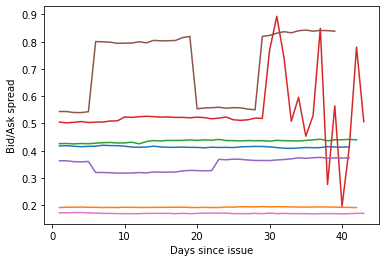

In [87]:
for ric in bond_data.Instrument.unique():
    instrument = bond_data[bond_data.Instrument == ric]
    
    plt.plot(instrument.obs_number, instrument["Spread"])

plt.xlabel("Days since issue")
plt.ylabel("Bid/Ask spread");

That's it folks, now you only have to actually write your project or Master's thesis ;)

In [ ]:
import torch

you.write_master()